<a href="https://colab.research.google.com/github/tristatsao/Customer-Lifetime-Value-of-Google-Merchandise-Store/blob/main/CLV%20project-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Analytics 360**
# New Customer Acquisition Lifetime Value Prediction
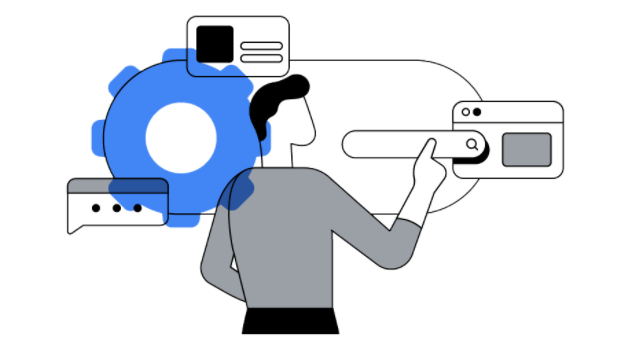

This notebook provides an example of training a customer "lifetime" value model for newly acquired e-commerce customers. It is meant to outline the minimum steps required to train this type of model and can be used as a starting point for your project. It is **not** meant to illustrate best practices or preferred approaches for this type of modeling.

The notebook references publicly available sample of Analytics 360 data, which is accessible through Google Cloud Platform's BigQuery data warehouse. The data was collected from the Google Merchandise Store, which sells Google promotional products like t-shirts, pens, phone accessories, mugs, etc.

For each newly acquired customer, we would like to make an estimate of the *future* revenue we can expect from this customer. We will make a prediction one week after the customer is acquired to estimate their revenue up to 90 days after their acquisition date. By combining this predicted revenue with the actual revenue generated from the customer's first purchase and any subsequent purchase during their first week, we can get a more hollistic view of the value of the acquisition. By providing this value (first transaction revenue + subsequent week 1 revenue + day 8-90 predicted revenue) to Google advertising platforms, Google can automatically optimize digital ads to help acquire higher value new customers.

## Creating training, testing & holdout datasets

In [ ]:
# Authenticate using Google OAuth 2.0
# This will provide the credentials necessary to use Google APIs within this notebook (e.g. BigQuery API)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Query the Analytics 360 sample in BigQuery and store results as a Pandas dataframe
import pandas as pd
import numpy as np
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Change the project to the ID of your personal GCP project
# You can find this ID by going to BQ, clicking on your project name at the top of the UI and finding the ID listed for your project name in the pop-up
project = 'project-501-9'

credentials, project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bqclient = bigquery.Client(credentials=credentials, project=project,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# The query below finds the first transaction of each customer before 05/01/2017
# It summarizes some information from the session where that transaction occurred (e.g. revenue, time on site, page views, etc.)
# It then summarizes some information from subsequent sessions that happen within 7 days of the first transaction session (e.g. additional visits, additional transactions)
# It then sums any subsequent revenue received from that customer over the next 8-90 days, which will be the target for our model
# Again, this is only example query. Feel free to edit and expand on this query to generate better features or a different dataset structure.
# (For example, you could also include data from sessions that happened *before* the customer's acquisition session to help make your prediction...Just don't include data from more than 7 days after their acquisition session!)
# Comments are added within the query. You can copy & paste this query into the BigQuery UI for easier readability
sql = """ 
WITH first_purchases AS (
# Find the start time for the session when the customer made their first purchase
SELECT 
       fullVisitorId, # Consider this the customer ID
    MIN(PARSE_TIMESTAMP('%s', CAST(visitStartTime AS string))) firstPurchaseSessionTime, # This will show "UTC" as the timezone but I think it's actually Pacific
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States' # Only looking at US acquisitions so we can assume everything is in USD
GROUP BY
    fullVisitorId
), 

first_purchases_sessions AS (
# Get session-level data from the session when the customer made their first purchase
# You'll see later that we have to query session-level data and hit-level data separately
SELECT 
    fp.fullVisitorId,
    ROUND(SUM(totals.transactionRevenue/1000000),2) AS revenue, # I've aggregated all the metrics here but really I don't have to since these are "totals" fields (i.e. session-level) and there will only be one session per customer
    MAX(visitNumber) AS visitNumber,
    SUM(totals.hits) AS hits,
    SUM(totals.pageviews) AS pageviews,
    COALESCE(SUM(totals.timeOnSite),0) AS timeOnSite,
    MAX(CASE WHEN channelGrouping = 'Referral' THEN 1 ELSE 0 END) AS referralChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Organic Search' THEN 1 ELSE 0 END) AS organicSearchChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Direct' THEN 1 ELSE 0 END) AS directChannelGrouping,
    MAX(CASE WHEN channelGrouping = 'Paid Search' THEN 1 ELSE 0 END) AS paidSearchChannelGrouping,
    MAX(CASE WHEN device.browser = 'Chrome' THEN 1 ELSE 0 END) AS chromeBrowser,
    MAX(CASE WHEN device.browser = 'Safari' THEN 1 ELSE 0 END) AS safariBrowser,
    MAX(CASE WHEN device.operatingSystem = 'Macintosh' THEN 1 ELSE 0 END) AS macintoshOS,
    MAX(CASE WHEN device.operatingSystem = 'Windows' THEN 1 ELSE 0 END) AS windowsOS,
    MAX(CASE WHEN device.operatingSystem = 'Chrome OS' THEN 1 ELSE 0 END) AS chromeOS,
    MAX(CASE WHEN device.operatingSystem = 'Linux' THEN 1 ELSE 0 END) AS LinuxOS,
    MAX(CASE WHEN geoNetwork.region = 'California' THEN 1 ELSE 0 END) AS california, # dummy variable indicating if the customer was in California
    MAX(CASE WHEN geoNetwork.region = 'New York' THEN 1 ELSE 0 END) AS newYork, # dummy variable indicating if the customer was in California
    MAX(CASE WHEN geoNetwork.metro = 'San Francisco-Oakland-San Jose CA' THEN 1 ELSE 0 END) AS bayArea,
    MAX(CASE WHEN (EXTRACT(Dayofweek FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC"))=1 OR(EXTRACT(Dayofweek FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC"))=7 THEN 1 ELSE 0 END) AS Weekend,
    MAX(CASE WHEN trafficSource.isTrueDirect = TRUE THEN 1 ELSE 0 END) AS TrafficSourceTrueDirect,
    MAX(totals.transactionRevenue/1000000) AS Maxspending,
    MAX(CASE WHEN (EXTRACT(Quarter FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC"))=1 THEN 1 ELSE 0 END )AS Q1,
    MAX(CASE WHEN (EXTRACT(Quarter FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC"))=2 THEN 1 ELSE 0 END )AS Q2,
    MAX(CASE WHEN (EXTRACT(Quarter FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC"))=3 THEN 1 ELSE 0 END )AS Q3,
    MAX(CASE WHEN (EXTRACT(Quarter FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC"))=4 THEN 1 ELSE 0 END )AS Q4,
    MAX(EXTRACT(Month FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC")) AS Month,
    MAX(EXTRACT(Week FROM (SELECT PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING)))AT TIME ZONE "UTC")) AS Week
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
JOIN
    first_purchases fp
ON
    ga.fullVisitorId = fp.fullVisitorId
    AND PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)) = fp.firstPurchaseSessionTime # Only getting data from first purchase
WHERE
    _TABLE_SUFFIX < '20170501' 
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States'
GROUP BY
    fp.fullVisitorId
),

first_purchases_hits AS (
# Get hit-level data from the session when the customer made their first purchase
# Hit data is stored in nested fields so we have to query it separately from the session-level data or else the session-level data aggregations would be incorrect
SELECT 
    fp.fullVisitorId,
    SUM(CASE WHEN hits.eCommerceAction.action_type = '6' THEN product.productQuantity ELSE 0 END) AS productQuantityPurchased, # Product quantity in the final transaction
    MAX(CASE WHEN product.v2ProductCategory LIKE "%Apparel%" AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS apparelPurchased, # dummy variable indicating if any apparel was purchased
    MAX(CASE WHEN product.v2ProductCategory LIKE "%Office%" AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS officePurchased,# dummy variable indicating if any office supplies were purchased
    MAX(CASE WHEN product.v2ProductCategory LIKE '%Drinkware%' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS drinkwarePurchased,
    MAX(CASE WHEN product.v2ProductCategory = 'Lifestyle' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS lifestylePurchased,
    MAX(CASE WHEN product.v2ProductCategory LIKE '%Bags%' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS bagsPurchased,
    MAX(CASE WHEN product.v2ProductCategory LIKE '%Electronics%' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS electronicsPurchased,# dummy variable indicating if any electronics were purchased
    MAX(CASE WHEN product.v2ProductCategory LIKE '%YouTube%' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS BrandYoutubePurchased,
    MAX(CASE WHEN product.v2ProductCategory LIKE '%Android%' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS BrandAndroidPurchased,
    MAX(CASE WHEN product.v2ProductCategory LIKE '%Google%' AND hits.eCommerceAction.action_type = '6' THEN 1 ELSE 0 END) AS BrandGooglePurchased,
    MAX(CASE WHEN hits.eCommerceAction.action_type = '4' THEN 1 ELSE 0 END) AS removedItemFromCart, # dummy variable indicating if they removed something from their cart during the session
    MAX(CASE WHEN hits.eCommerceAction.action_type = '3' THEN 1 ELSE 0 END) AS addedItemtoCart, 
    MAX(CASE WHEN hits.promotionActionInfo IS NOT NULL THEN 1 ELSE 0 END) AS Promotion, # purchase occurs when promotion happened
    Max(CASE WHEN hits.social.hasSocialSourceReferral = 'Yes' THEN 1 ELSE 0 END) As HasSocialSourceReferral,
    MAX(product.productPrice/1000000) AS Maxproductprice
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga,
    UNNEST(hits) hits,
    UNNEST(hits.product) product
JOIN
    first_purchases fp
ON
    ga.fullVisitorId = fp.fullVisitorId
    AND PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)) = fp.firstPurchaseSessionTime # Only getting data from first purchase
WHERE
    _TABLE_SUFFIX < '20170501' 
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
    AND geoNetwork.country = 'United States'
GROUP BY
    fp.fullVisitorId
),

# Get session level data that occured after the first purchase session but within 7 days of that session
# Looking to see if the user came back within a week and had any additional activity
first_week_sessions AS (
SELECT 
    fp.fullVisitorId,
    COALESCE(SUM(ga.totals.visits),0) AS firstWeekVisits, # Visits from first week of acquisition, excluding acquisition session
    COALESCE(SUM(ga.totals.transactions),0) AS firstWeekTransactions, # Transactions from first week of acquisition, excluding acquisition session
    COALESCE(ROUND(SUM(ga.totals.transactionRevenue/1000000),2),0) AS firstWeekRevenue, # Revenue from first week of acquisition, excluding acquisition session
    COALESCE(ROUND(SUM(totals.transactionRevenue/1000000)/ COUNT(fp.fullVisitorId),2),0) AS avg_transactions_per_user,
    COALESCE(SUM(totals.pageviews) / COUNT(fp.fullVisitorid),0)  AS avg_pageviews_per_user,
    COALESCE(SUM(totals.bounces) / SUM(totals.visits),0) AS bounceRate  
#promotion perhaps did matter!->add afterward
FROM 
    first_purchases fp
LEFT JOIN
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, HOUR) BETWEEN 1 AND 168 # Consider visits between 1 hour and 7 days after first purchase session
GROUP BY 
    fp.fullVisitorId
),

first_week_hits AS(
  SELECT 
    fp.fullVisitorId,
    COALESCE(MAX(CASE WHEN hits.eCommerceAction.action_type = '4' THEN 1 ELSE 0 END),0) AS removedItemFromCart_week, # dummy variable indicating if they removed something from their cart during the session
    COALESCE(MAX(CASE WHEN hits.eCommerceAction.action_type = '3' THEN 1 ELSE 0 END),0) AS addedItemtoCart_week, 
    COALESCE(MAX(CASE WHEN hits.social.hasSocialSourceReferral = 'Yes' THEN 1 ELSE 0 END),0) As HasSocialSourceReferral_week,
    COALESCE(MAX(CASE WHEN hits.promotionActionInfo IS NOT NULL THEN 1 ELSE 0 END),0) AS Promotion_1
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga

CROSS JOIN   UNNEST(hits) hits
Right JOIN
    first_purchases fp
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, HOUR) BETWEEN 1 AND 168 # Consider visits between 1 hour and 7 days after first purchase session
GROUP BY 
    fp.fullVisitorId
),

future_purchases AS (
# For each newly acquired customer, look for any purchases that occurred in the next 8-90 days
SELECT
    fp.fullVisitorId,
    ROUND(SUM(ga.totals.transactionRevenue/1000000),2) AS futureRevenue # This is our model target
FROM 
    first_purchases fp
LEFT JOIN
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` ga
ON 
    fp.fullVisitorId = ga.fullVisitorId
    AND TIMESTAMP_DIFF(PARSE_TIMESTAMP('%s', CAST(ga.visitStartTime AS string)), fp.firstPurchaseSessionTime, DAY) BETWEEN 8 AND 90 # Consider purchases between 8-90 days after acquisition
WHERE 
    ga.totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY 
    fp.fullVisitorId
),

Daytime_All AS(
  SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="New York" 
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Los_Angeles"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="California"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Chicago"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Illinois"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Los_Angeles"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Washington"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Chicago"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Texas"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Michigan"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Massachusetts"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="District of Columbia"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Georgia"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Virginia"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Pennsylvania"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Denver"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Colorado"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="North Carolina"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Denver"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Arizona"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Florida"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="New Jersey"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Tennessee"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Ohio"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Los_Angeles"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Oregon"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Chicago"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Minnesota"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Chicago"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Nebraska"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Chicago"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Missouri"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Chicago"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Iowa"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="South Carolina"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Los_Angeles"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Nevada"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/Denver"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Utah"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Indiana"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 

UNION ALL
SELECT fullVisitorId, 
CASE WHEN (EXTRACT(HOUR FROM DATETIME(MIN(PARSE_TIMESTAMP("%s", CAST (GA.visitStartTime AS STRING))), "America/New_York"))) BETWEEN 7 AND 17 THEN 1 ELSE 0 END AS daytime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` GA
WHERE geoNetwork.region="Connecticut"
AND _TABLE_SUFFIX < '20170501' # The sample data ends in 08/2017 so we want to only look at acquisitions before 05/2017 to ensure they all have at least 90 days of subsequent data available
    AND totals.transactions > 0
    AND totals.transactionRevenue > 0
GROUP BY fullVisitorId 
)

# Join the list of newly acquired customers to their acquisition session-level data, acquisition hit-level data, first week session-level data, and future day 8-90 revenue
SELECT
    first_purchases.*,
    first_purchases_sessions.* EXCEPT(fullVisitorId),
    first_purchases_hits.* EXCEPT(fullVisitorId),
    first_week_sessions.* EXCEPT(fullVisitorId),
    COALESCE(future_purchases.futureRevenue,0) AS futureRevenue,
    Daytime_All.*EXCEPT(fullVisitorId),
    first_week_hits.* EXCEPT(fullVisitorId)
FROM 
    first_purchases
LEFT JOIN 
    first_purchases_sessions 
USING(fullVisitorId)
LEFT JOIN 
    first_purchases_hits 
USING(fullVisitorId)
LEFT JOIN 
    future_purchases 
USING(fullVisitorId)
LEFT JOIN
    first_week_sessions 
USING(fullVisitorId)
LEFT JOIN
Daytime_All
USING(fullVisitorId)
LEFT JOIN
first_week_hits
USING(fullVisitorId)
"""

# Store query results as Panada dataframe
df = pd.read_gbq(sql, project_id=project, dialect='standard', use_bqstorage_api=True)

In [ ]:
df.head(5)

,fullVisitorId,firstPurchaseSessionTime,revenue,visitNumber,hits,pageviews,timeOnSite,referralChannelGrouping,organicSearchChannelGrouping,directChannelGrouping,paidSearchChannelGrouping,chromeBrowser,safariBrowser,macintoshOS,windowsOS,chromeOS,LinuxOS,california,newYork,bayArea,Weekend,TrafficSourceTrueDirect,Maxspending,Q1,Q2,Q3,Q4,productQuantityPurchased,apparelPurchased,officePurchased,drinkwarePurchased,lifestylePurchased,bagsPurchased,electronicsPurchased,BrandYoutubePurchased,BrandAndroidPurchased,BrandGooglePurchased,removedItemFromCart,addedItemtoCart,Promotion,HasSocialSourceReferral,Maxproductprice,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,bounceRate,futureRevenue,daytime
0,3725836239165941255,2017-01-02 04:04:09+00:00,75.18,1,52,40,2402,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,75.18,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,95.99,0,0,0.0,0.0,0.0,NaN
1,5612267454123483298,2017-02-19 00:34:35+00:00,23.17,3,49,37,955,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,23.17,1,0,0,0,3,1,0,1,0,0,0,0,0,0,0,1,0,0,47.99,0,0,0.0,0.0,0.0,0.0
2,1464880667814734999,2016-09-08 16:53:55+00:00,12.58,4,33,30,1020,1,0,0,0,1,0,0,0,0,1,1,0,1,0,1,12.58,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,44.79,0,0,0.0,0.0,0.0,1.0
3,5301053283618426279,2016-09-08 21:38:36+00:00,123.38,4,130,96,1513,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,123.38,0,0,1,0,18,0,0,0,0,0,0,0,0,0,0,1,0,0,119.99,0,0,0.0,0.0,0.0,1.0
4,1901353870943864683,2017-04-24 17:51:08+00:00,21.99,1,27,22,1595,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,21.99,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,24.99,1,0,0.0,1.0,0.0,NaN


In [ ]:
# Create development and holdout datasets
# Dev data will be further split into training and testing data
# The holdout data will be used to get a final estimate of the model's performance
dev_data = df[df['firstPurchaseSessionTime'] < '2017-04-01 00:00:00 UTC']
holdout_data = df[df['firstPurchaseSessionTime'] >= '2017-04-01 00:00:00 UTC']

## Exploratory Data Analysis

In [ ]:
!pip install pycaret
#from pycaret.utils import enable_colab
#enable_colab()
from pycaret.regression import *

In [ ]:
eda_data = dev_data.drop(['fullVisitorId', 'firstPurchaseSessionTime'], axis=1) # Exclude fullVisitorId and firstPurchaseSessionTime from EDA
eda_data = eda_data.reset_index(drop=True)

pc_eda = setup(data = eda_data, target = 'futureRevenue', session_id=123 , profile=True)

Based on the exploratory data analysis above, a few things are evident.
- There are outliers present with respect to both the dependent and independent variables. Specifically, there are a few high values for futureRevenue, revenue, visitNumber and productQuantityPurchased. For simplicity, I will drop records containing these outliers.
- Unfortunately it doesn't look like there are any high correlations between the futureRevenue and other variables. This will make modeling challenging.
- 93% of futureRevenue values are 0. This will likely present a challenge for modeling. 

In [ ]:
# Drop records with outlier values and re-do EDA                     TA Anything above 99%ile is an outlier
eda_data_v2 = eda_data.drop(
                    eda_data[(eda_data['futureRevenue'] >= 10000.00) 
                    | (eda_data['revenue'] >= 10000.00)
                    | (eda_data['visitNumber'] >= 150) 
                    | (eda_data['productQuantityPurchased'] >= 1500)].index)

eda_data_v2 = eda_data_v2.reset_index(drop=True)

pc_eda_v2 = setup(data = eda_data_v2, target = 'futureRevenue', session_id=123 , profile=True)

Only two records were dropped after removing outliers based on the conditions above. I could probably be more aggressive removing or treating outliers. A lot of the variables have very skewed distributions with long tails.

## Model training

In [ ]:
# This notebook will only test developing models with XGBoost but this is just an example
# Feel free to use any libraries/frameworks you feel are appropriate
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, r2_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import ResidualsPlot

### Initial model

[17:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training RMSE:  169.37
Training R-Squared:  0.15

Testing RMSE:  119.4
Testing R-Squared:  -0.0

Prediction Error Plot


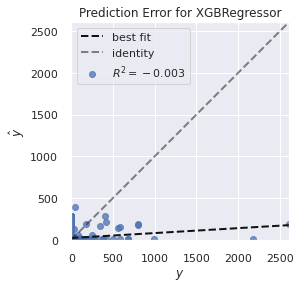

In [ ]:
# Drop the same rows dropped during EDA
dev_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 150) 
                    | (dev_data['productQuantityPurchased'] >= 1500)].index)

dev_data = dev_data.reset_index(drop=True)

# Setup the data for SK Learn
X = dev_data.drop(['fullVisitorId','firstPurchaseSessionTime','futureRevenue'], axis=1) # Feature matrix in pd.DataFrame format...fullVisitorId, session time, and future revenue aren't being used as predictor variables
y = pd.Series(dev_data.futureRevenue) # Target vector in pd.Series format

# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
model = xgb.XGBRegressor(max_depth=1, n_estimators=20,
                           reg_alpha=10, reg_lambda=0,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=123, learning_rate=0.10)

#model = LinearRegression()
#model = DecisionTreeRegressor(max_depth=3)

# Fit the data(train the model)
model.fit(X_train, y_train)

# Calculate RMSE and R^2 for training data
train_y_pred = model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Calculate RMSE and R^2 for testing data
test_y_pred = model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(model, X_train, y_train, X_test, y_test)
viz.show() # Sometimes visualization fails after using PyCaret EDA... Have to restart runtime and skip EDA

This is a bad model. The R-squared is very low. It is also clear that most predictions are very close to 0.

There is an opportunity to improve this model through hyperparameter tuning or trying a different model algorithm. However, given the model performance is this bad, I think a more significant change is required.

There are two things I would try:
1) Go back to the original data source and see if there are additional features that could be added to the model that are more predictive than our initial feature set. Additional feature engineering could also be done with the data we currently have. (e.g. Use the firstPurchaseSessionTime field to create a feature indicating if the user purchased on during the weekday or on the weekend.) I'm not going to add more data or do feature engineering right now but it would be great to see what you come up with.
2) Since there are so many 0 values for futureRevenue, it could be helpful to split this model into two parts. The first part will be a regression model trained on only users with non-zero futureRevenue. The second part will be a classification model trained on all users predicting the probability that they will make at least one future purchase. Our final prediction can be one of three options:
 - If our regression model is good but our classification model is bad, the prediction will be [Regression Model Prediction] * [Average Repeat Purchase Rate]
 - If our regression model is bad but our classification model is good, the prediction will be [Average futureValue] * [Classification Model Prediction]
 - If our regression model is good and our classification model is good, the prediction will be [Regression Model Prediction] * [Classification Model Prediction]

I am going to move forward and show an example of separating the model into a regression model and a classification model. This approach generally works best when the variables that are predictive for the regression model are different than the variables that are predictive for the classification model. I don't know if that will be the case here.

### Regression model (repeat purchasers only)

In [ ]:
# Drop the same rows dropped during EDA
# Also drop any rows where futureRevenue = 0
reg_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 100) 
                    | (dev_data['productQuantityPurchased'] >= 1000)
                    | (dev_data['futureRevenue'] == 0)].index)

reg_data = reg_data.reset_index(drop=True)

# Look at correlation between futureRevenue and other variables to select initial feature set
reg_data[reg_data.columns[1:]].corr()['futureRevenue'][:-1]

revenue                         0.362663
visitNumber                     0.045339
hits                            0.187032
pageviews                       0.200819
timeOnSite                      0.168338
referralChannelGrouping        -0.196190
organicSearchChannelGrouping   -0.057873
directChannelGrouping           0.274020
paidSearchChannelGrouping       0.025719
chromeBrowser                  -0.037515
safariBrowser                   0.076230
macintoshOS                    -0.146410
windowsOS                       0.059102
chromeOS                        0.207824
LinuxOS                        -0.081161
california                     -0.131329
newYork                        -0.032514
bayArea                        -0.142818
Weekend                        -0.062314
TrafficSourceTrueDirect         0.119904
Maxspending                     0.362663
Q1                             -0.101958
Q2                                   NaN
Q3                             -0.080338
Q4              

In [ ]:
#Normalize 
reg_data_n=reg_data[['revenue', 'visitNumber','hits','pageviews','timeOnSite','firstWeekVisits','firstWeekTransactions','firstWeekRevenue','futureRevenue']]
normalized_reg_df=(reg_data_n-reg_data_n.mean())/reg_data_n.std()
normalized_reg_df.head()

,revenue,visitNumber,hits,pageviews,timeOnSite,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,futureRevenue
0,-0.097356,-0.514554,1.126452,1.451687,0.216524,-0.534433,-0.303997,-0.170499,-0.237269
1,-0.424665,-0.514554,-0.137505,-0.158919,-0.229103,-0.534433,-0.303997,-0.170499,-0.505899
2,-0.164657,-0.339328,0.043060,0.319910,0.446433,-0.534433,-0.303997,-0.170499,0.189925
3,-0.357127,-0.164101,1.216735,1.277568,-0.457119,0.140882,-0.303997,-0.170499,-0.498939
4,-0.598388,-0.164101,-0.859767,-0.855397,-0.596200,0.140882,-0.303997,-0.170499,-0.380536


In [ ]:
#join back 
normal_all=normalized_reg_df.join(reg_data.drop(['revenue', 'visitNumber','hits','pageviews','timeOnSite','firstWeekVisits','firstWeekTransactions','firstWeekRevenue','futureRevenue'],axis=1))
normal_all.head()

,revenue,visitNumber,hits,pageviews,timeOnSite,firstWeekVisits,firstWeekTransactions,firstWeekRevenue,futureRevenue,fullVisitorId,firstPurchaseSessionTime,referralChannelGrouping,organicSearchChannelGrouping,directChannelGrouping,paidSearchChannelGrouping,chromeBrowser,safariBrowser,macintoshOS,windowsOS,chromeOS,LinuxOS,california,newYork,bayArea,Weekend,TrafficSourceTrueDirect,Maxspending,Q1,Q2,Q3,Q4,productQuantityPurchased,apparelPurchased,officePurchased,drinkwarePurchased,lifestylePurchased,bagsPurchased,electronicsPurchased,BrandYoutubePurchased,BrandAndroidPurchased,BrandGooglePurchased,removedItemFromCart,addedItemtoCart,Promotion,HasSocialSourceReferral,Maxproductprice,bounceRate,daytime
0,-0.097356,-0.514554,1.126452,1.451687,0.216524,-0.534433,-0.303997,-0.170499,-0.237269,5002959687839673544,2016-08-05 21:27:43+00:00,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,183.44,0,0,1,0,5,0,0,0,0,0,0,0,0,0,1,1,0,0,119.99,0.0,1.0
1,-0.424665,-0.514554,-0.137505,-0.158919,-0.229103,-0.534433,-0.303997,-0.170499,-0.505899,3535157243408917520,2016-11-22 04:37:22+00:00,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,72.75,0,0,0,1,5,1,0,0,0,0,0,0,0,0,1,1,0,0,89.99,0.0,NaN
2,-0.164657,-0.339328,0.043060,0.319910,0.446433,-0.534433,-0.303997,-0.170499,0.189925,5263059809967138936,2017-02-21 16:10:38+00:00,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,160.68,1,0,0,0,12,1,1,0,0,0,0,0,0,0,0,1,0,0,145.99,0.0,1.0
3,-0.357127,-0.164101,1.216735,1.277568,-0.457119,0.140882,-0.303997,-0.170499,-0.498939,1884511874414753238,2016-08-08 05:42:32+00:00,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,95.59,0,0,1,0,15,0,0,0,0,0,0,0,0,0,0,1,0,0,250.00,1.0,0.0
4,-0.598388,-0.164101,-0.859767,-0.855397,-0.596200,0.140882,-0.303997,-0.170499,-0.380536,2449425615576273633,2016-11-25 17:42:29+00:00,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,14.00,0,0,0,1,4,0,0,0,0,1,0,0,0,0,0,1,0,0,119.99,0.0,NaN


In [ ]:
#correlation
normal_all[normal_all.columns[1:]].corr()['futureRevenue'][:]

visitNumber                     0.045339
hits                            0.187032
pageviews                       0.200819
timeOnSite                      0.168338
firstWeekVisits                 0.065343
firstWeekTransactions           0.115839
firstWeekRevenue                0.194428
futureRevenue                   1.000000
referralChannelGrouping        -0.196190
organicSearchChannelGrouping   -0.057873
directChannelGrouping           0.274020
paidSearchChannelGrouping       0.025719
chromeBrowser                  -0.037515
safariBrowser                   0.076230
macintoshOS                    -0.146410
windowsOS                       0.059102
chromeOS                        0.207824
LinuxOS                        -0.081161
california                     -0.131329
newYork                        -0.032514
bayArea                        -0.142818
Weekend                        -0.062314
TrafficSourceTrueDirect         0.119904
Maxspending                     0.362663
Q1              

[17:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training RMSE:  402.54
Training R-Squared:  0.47

Testing RMSE:  513.88
Testing R-Squared:  0.28

Prediction Error Plot


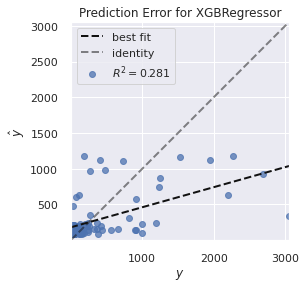

In [ ]:
# Setup the data for SK Learn

# Feature matrix will include variables with largest correlations to futureRevenue
X = reg_data[['revenue','hits','pageviews','timeOnSite','referralChannelGrouping','directChannelGrouping','Maxspending','Q4','electronicsPurchased','officePurchased','lifestylePurchased','chromeOS','productQuantityPurchased','Maxproductprice','firstWeekRevenue']]
y = pd.Series(reg_data.futureRevenue) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
reg_model = xgb.XGBRegressor(max_depth=1, n_estimators=100,
                           reg_alpha=100, reg_lambda=10,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=123, learning_rate=0.10)

#reg_model = LinearRegression()
#reg_model = DecisionTreeRegressor(max_depth=3)

# Fit the data(train the model)
reg_model.fit(X_train, y_train)

# Get RMSE and R^2 for training data
train_y_pred = reg_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

Training_MSE = mse(train_y_true, train_y_pred)
Training_RMSE = np.sqrt(Training_MSE)

Training_R_squared = r2_score(train_y_true, train_y_pred)

# Get RMSE and R^2 for testing data
test_y_pred = reg_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data

Testing_MSE = mse(test_y_true, test_y_pred)
Testing_RMSE = np.sqrt(Testing_MSE)

Testing_R_squared = r2_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("\nTraining RMSE: ", np.round(Training_RMSE, 2))
print("Training R-Squared: ", np.round(Training_R_squared, 2))

print("\nTesting RMSE: ", np.round(Testing_RMSE, 2))
print("Testing R-Squared: ", np.round(Testing_R_squared, 2))

# Visualize the Prediction Error Plot
print("\nPrediction Error Plot")
viz = prediction_error(reg_model, X_train, y_train, X_test, y_test)
viz.show()

We're able to make a significantly better model predicting futureValue for repeat purchasers only. R-Squared of 0.35 still isn't great but it's a lot better than our first model.

Additional features, feature engineering, and hyperparameter tuning could improve this model further.

### Classification model (likelihood to purchase again)

In [ ]:
# Drop the same rows dropped during EDA
# We will include both repeat purchasers and single purchasers here since we're trying to predict repeat purchase
cla_data = dev_data.drop(
                    dev_data[(dev_data['futureRevenue'] >= 10000.00) 
                    | (dev_data['revenue'] >= 10000.00)
                    | (dev_data['visitNumber'] >= 100) 
                    | (dev_data['productQuantityPurchased'] >= 1000)].index)

# Add column to represent a user that purchased again
# This will be our model's target
cla_data['repeatPurchaser'] = np.where(cla_data['futureRevenue'] > 0, 1, 0)

dev_data = dev_data.reset_index(drop=True)

# Look at correlation between repeatPurchaser and other variables to select initial feature set
# Correlation isn't the best metric to look at for a classification problem. 
# Feel free to use another technique to select your intial features.
cla_data[cla_data.columns[1:]].corr()['repeatPurchaser'][:-1]

revenue                         0.120940
visitNumber                     0.088569
hits                            0.069451
pageviews                       0.063192
timeOnSite                      0.053665
referralChannelGrouping         0.029061
organicSearchChannelGrouping   -0.058179
directChannelGrouping           0.050635
paidSearchChannelGrouping      -0.030333
chromeBrowser                   0.032709
safariBrowser                  -0.031003
macintoshOS                     0.051852
windowsOS                      -0.025082
chromeOS                        0.040661
LinuxOS                        -0.041832
california                     -0.022611
newYork                         0.044598
bayArea                        -0.022069
Weekend                        -0.020230
TrafficSourceTrueDirect         0.073894
Maxspending                     0.120940
Q1                              0.003761
Q2                                   NaN
Q3                              0.007702
Q4              

In [ ]:
# Setup the data for SK Learn

# Feature matrix will include variables with largest correlations to repeatVisitor (excluding futureRevenue, which we can't use)
X = cla_data[['revenue','productQuantityPurchased','firstWeekRevenue','Maxspending','visitNumber','TrafficSourceTrueDirect','Maxproductprice','firstWeekTransactions']]
y = pd.Series(cla_data.repeatPurchaser) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

# Instantiate XGBoost object with hyperparameters...No hyperparameter tuning is included in this example but would be beneficial
cla_model = xgb.XGBClassifier(max_depth=5, n_estimators=100,
                           reg_alpha=0.5, reg_lambda=0,
                           objective="binary:logistic", booster='gbtree',
                           random_state=123, learning_rate=0.1)
#cla_model = LogisticRegression()
#cla_model = DecisionTreeClassifier()

# Fit the data(train the model)
cla_model.fit(X_train, y_train)

# Calculate evaluation metrics for classification model
train_y_pred = cla_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

test_y_pred = cla_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data


print('\n clasification report:\n', classification_report(test_y_true, test_y_pred))
print('\n confussion matrix:\n',confusion_matrix(test_y_true, test_y_pred))
print('\n ROC AUC: \n',roc_auc_score(test_y_true, test_y_pred))


 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1127
           1       0.17      0.02      0.04       101

    accuracy                           0.91      1228
   macro avg       0.54      0.51      0.49      1228
weighted avg       0.86      0.91      0.88      1228


 confussion matrix:
 [[1117   10]
 [  99    2]]

 ROC AUC: 
 0.5054644328674216


In [ ]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Setup the data for SK Learn

# Feature matrix will include variables with largest correlations to repeatVisitor (excluding futureRevenue, which we can't use)
X = cla_data[['revenue','productQuantityPurchased','firstWeekRevenue','Maxspending','visitNumber','TrafficSourceTrueDirect','Maxproductprice','firstWeekTransactions']]
y = pd.Series(cla_data.repeatPurchaser) # Target vector in pd.Series format



# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, shuffle=True)

cla_model = GaussianNB()

# Fit the data(train the model)
cla_model.fit(X_train, y_train)

# Calculate evaluation metrics for classification model
train_y_pred = cla_model.predict(X_train) # Predictions for training data
train_y_true = y_train # True values for training data

test_y_pred = cla_model.predict(X_test) # Predictions for testing data
test_y_true = y_test # True values for testing data


print('\n clasification report:\n', classification_report(test_y_true, test_y_pred))
print('\n confussion matrix:\n',confusion_matrix(test_y_true, test_y_pred))
print('\n ROC AUC: \n',roc_auc_score(test_y_true, test_y_pred))


 clasification report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1137
           1       0.19      0.14      0.16        91

    accuracy                           0.89      1228
   macro avg       0.56      0.55      0.55      1228
weighted avg       0.88      0.89      0.88      1228


 confussion matrix:
 [[1082   55]
 [  78   13]]

 ROC AUC: 
 0.547242115843699


This is a bad model. For reference, ROC AUC of 0.5 is equivalent to a random guess for the classification. Additional features, feature engineering, hyperparameter tuning or a different model algorithm might be able to produce better predictions.

## Holdout predictions

As a final step, I'm comparing different options for making a prediction to a "naive estimate." The three options I will consider for making a prediction are:
- Naive estimate, which assumes each customer's 8-90 day future revenue will be equal to the average future revenue observed in the development dataset.
- Initial model's predictions. This was the first model with the low R-squared.
- Regression only model, which will take the predictions from the regression model trained on repeat purchasers multiplied by the average repeat purchase rate observered in the development dataset. 

Note, I did not consider any options using the classification model since that model's performance was very poor. If you can create a classification model with better performance, I would suggest you try using it here.

I will evaluate the model based on three metrics:
- Mean absolute error, the primary KPI
- Mean squared error, which is more sensitive to extreme errors
- Average error, which will indicate overall prediction bias

The regression only model trained on repeat purchasers performed the best out of the options available. It lowered the MAE significantly compared to the naive estimate. It also had a lower prediction bias (measured by average prediction error) compared to the naive estimate. The naive estimate would tend to over-predict for the holdout dataset more than the regression only model.

Having said that, these predictions still aren't very good. I was able to reduce the MAE ~23% compared to a naive estimate. I generally try to reduce MAE at least 30-50% before testing this type of model in a digital advertising campaign.

For this project, I would be interested to see the following:
- What additional features can you create from the source dataset to improve either the regression only model or classification only model?
- What additional insights can you find through exploratory data analysis? Are there other variables that are good predictors of futureValue, or at least repeat purchase probability?
- What hyperparameter tuning can you do to improve the models' performance?
- Are there more suitable model algorithms to use to solve this problem?
- How can we clean up this notebook to make it more generalizable/easier to use for other advertisers?

In [ ]:
#Use regression, classfication models to predict future revenue.

# Set up holdout data for initial model
X_holdout = holdout_data.drop(['fullVisitorId', 'firstPurchaseSessionTime','futureRevenue'], axis=1) 
y_holdout = pd.Series(holdout_data.futureRevenue)

holdout_y_pred = model.predict(X_holdout) # Initial model predictions for holdout data
holdout_y_true = y_holdout # True values for holdout data

# Set up data for regression only model
reg_X_holdout = holdout_data[['revenue','hits','pageviews','timeOnSite','referralChannelGrouping','directChannelGrouping','Maxspending','Q4','electronicsPurchased','officePurchased','lifestylePurchased','chromeOS','productQuantityPurchased','Maxproductprice','firstWeekRevenue']]
reg_holdout_y_pred = reg_model.predict(reg_X_holdout) # Regression only predictions for holdout data

cla_X_holdout = holdout_data[['revenue','productQuantityPurchased','firstWeekRevenue','Maxspending','visitNumber','TrafficSourceTrueDirect','Maxproductprice','firstWeekTransactions']]
cla_X_holdout_y_pred = cla_model.predict(cla_X_holdout)

Predict_model=cla_X_holdout_y_pred*reg_holdout_y_pred
# Get RMSE and MAE error based on naive estimate
#Naive_MAE = np.mean(np.absolute(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true))
#Naive_MSE = mse(pd.Series(holdout_data.NaiveEstimate), holdout_y_true)
#Naive_RMSE = np.sqrt(Naive_MSE)
#Naive_Avg_Error = np.mean(pd.Series(holdout_data.NaiveEstimate) - holdout_y_true)

# Get RMSE, MAE, and average error based on initial model predictions
Initial_Model_MAE = np.mean(np.absolute(holdout_y_true - holdout_y_pred))
Initial_Model_MSE = mse(holdout_y_true, holdout_y_pred)
Initial_Model_RMSE = np.sqrt(Initial_Model_MSE)
Initial_Model_Avg_Error = np.mean(holdout_y_true - holdout_y_pred)

# Get RMSE and MAE error based on regression*classification model
Predict_model_MAE = np.mean(np.absolute(holdout_y_true - reg_holdout_y_pred*cla_X_holdout_y_pred))
Predict_model_MSE = mse(holdout_y_true, reg_holdout_y_pred*cla_X_holdout_y_pred)
Predict_model_RMSE = np.sqrt(Predict_model_MSE)
Predict_model_Avg_Error = np.mean(reg_holdout_y_pred*cla_X_holdout_y_pred - holdout_y_true)

# Get RMSE and MAE error based on class only model
#Clas_Model_MAE = np.mean(np.absolute(holdout_y_true - cla_X_holdout_y_pred))
#Clas_Model_MsE = mse(holdout_y_true, cla_X_holdout_y_pred)
#Clas_Model_RMSE = np.sqrt(Clas_Model_MsE)
#Clas_Model_Avg_Error = np.mean(cla_X_holdout_y_pred - holdout_y_true)

#print("\nNaive MAE: ", np.round(Naive_MAE, 2))
#print("Naive RMSE: ", np.round(Naive_RMSE, 2))
#print("Naive Avg Error: ", np.round(Naive_Avg_Error, 2))

print("\nInitial Model MAE: ", np.round(Initial_Model_MAE, 2))
print("Initial Model RMSE: ", np.round(Initial_Model_RMSE, 2))
print("Initial Model Avg Error: ", np.round(Initial_Model_Avg_Error, 2))

#print("\nRegression Only Model MAE: ", np.round(Reg_Model_MAE, 2))
#print("Regression Only Model RMSE: ", np.round(Reg_Model_RMSE, 2))
#print("Regression Only Model Avg Error: ", np.round(Reg_Model_Avg_Error, 2))

print("\Predict_model_MAE MAE: ", np.round(Predict_model_MAE, 2))
print("Predict_model_MAE RMSE: ", np.round(Predict_model_RMSE, 2))
print("Predict_model_MAE Avg Error: ", np.round(Predict_model_Avg_Error, 2))


Initial Model MAE:  28.19
Initial Model RMSE:  75.44
Initial Model Avg Error:  -7.71
\Predict_model_MAE MAE:  35.82
Predict_model_MAE RMSE:  164.23
Predict_model_MAE Avg Error:  13.34
